In [1]:
import os

import numpy as np
import pandas as pd

def getDatasetPath(chosenDataset, withNoise):
    # folderNames is a dict containing as keys numbers from 1 to 7 and as values the folder names of the trajectory datasets
    folderNames = {1: "TRAJECTORY 1", 2: "TRAJECTORY 2", 3:"TRAJECTORY 3", 4: "TRAJECTORY 4", 5: "TRAJECTORY 5", 6: "TRAJECTORY 6", 7: "TRAJECTORY 7"}
    # datasets is a dict containing as keys numbers from 1 till 7 and as values tuples containing the names of the datasets
    datasets = {1: ("static_100Hz", "static_100Hz_with_noise"), 2: ("straight_50Hz", "straight_50Hz_with_noise"), 3: ("car_turns_100Hz", "car_turns_100Hz_with_noise"),
                    4: ("fast_car_50Hz", "fast_car_50Hz_with_noise"), 5: ("air_turns_50Hz", "air_turns_50Hz_with_noise"),
                    6: ("climb_and_descent_50Hz", "climb_and_descent_50Hz_with_noise"), 7: ("whole_flight_20Hz", "whole_flight_20Hz_with_noise")}
    folderPath = os.getcwd() + '/measurements/' + str(folderNames[chosenDataset]) + '/'
    filePath = folderPath + str(datasets[chosenDataset][1]) if withNoise else folderPath + str(datasets[chosenDataset][0])
    return folderPath, filePath

def getDataframe(filePath):
    with open(filePath, 'r') as f: # firstly open the text file for reading (r)
        contents = f.readlines() # read all the lines of the text file and return them as a list of strings
    Fs = np.zeros(shape=[1]) #sampling frequency
    P0 = np.zeros(shape=[1, 3]) #initial position of IMU
    V0 = np.zeros(shape=[1, 3]) #initial velocity of IMU
    E0 = np.zeros(shape=[1, 3]) #initial Euler Angles
    tempMeasurements = []
    indexStartMeasurements = []
    for index, line in enumerate(contents):
        if len(indexStartMeasurements) == 1:
            tempMeasurements.append(contents[index])
            continue
        if line.find("# Sampling frequency (Hz) :") >= 0: # if "# Sampling frequency (Hz) :" string is found, update Fs
            Fs[0] = float(contents[index + 1])
            continue
        if line.find("# IMU initial position :") >= 0: # if "# IMU initial position :" string is found, update P0
            P0[0] = eval(contents[index + 1])
            continue
        if line.find("# IMU initial velocity :") >= 0: # if "# IMU initial velocity :" string is found, update V0
            V0[0] = eval(contents[index + 1])
            continue
        if line.find("# IMU initial Euler's angles :") >= 0: # if "## IMU initial Euler's angles :" update E0
            E0[0] = eval(contents[index + 1])
        if line.find("Time (GPS)") >= 0: # if "Time (GPS) :" update indexStartMeasurements
            indexStartMeasurements.append(index)
            tempMeasurements.append(contents[index])
            continue

    df = pd.read_csv(filepath_or_buffer=filePath, sep="\t", header=indexStartMeasurements[0])
    df = df.loc[:, ~df.columns.str.startswith('Unnamed')] # drop columns in the dataframe that start with Unnamed
    df.to_csv('data.csv') # save the csv
    return Fs, P0, V0, E0, df


In [58]:
class KalmanFilter:
    def __init__(self, P0, V0, E0, R, dt):
        self.A = np.array([[1, 0, 0, dt, 0, 0, 0, 0, 0],
                          [0, 1, 0, 0, dt, 0, 0, 0, 0],
                          [0, 0, 1, 0, 0, dt, 0, 0, 0],
                          [0, 0, 0, 1, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 1, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 0, 0, 0, 1, 0, 0],
                          [0, 0, 0, 0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 0, 0, 0, 1]])

        self.B = np.array([[0.5*dt*dt, 0, 0, 0, 0, 0],
                          [0, 0.5*dt*dt, 0, 0, 0, 0],
                          [0, 0, 0.5*dt*dt, 0, 0, 0],
                          [dt, 0, 0, 0, 0, 0],
                          [0, dt, 0, 0, 0, 0],
                          [0, 0, dt, 0, 0, 0],
                          [0, 0, 0, dt, 0, 0],
                          [0, 0, 0, 0, dt, 0],
                          [0, 0, 0, 0, 0, dt]])
        self.n = np.shape(self.A)[0]                                # row dimension of the A matrix (9 states)
        self.x_initial = np.array([P0[0], V0[0], E0[0]]).reshape(self.n, 1)
        self.x = np.array([P0[0], V0[0], E0[0]]).reshape(self.n, 1) # state vector X as a 9x1 vector

        self.C = np.array([[0, 0, 0, (self.x[3][0] - self.x_initial[3][0])/dt, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0, (self.x[4][0] - self.x_initial[4][0])/dt, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0, (self.x[5][0] - self.x_initial[5][0])/dt, 0, 0, 0],
                          [0, 0, 0, 0, 0, 0, (self.x[6][0] - self.x_initial[6][0])/dt, 0, 0],
                          [0, 0, 0, 0, 0, 0, 0, (self.x[7][0] - self.x_initial[7][0])/dt, 0],
                          [0, 0, 0, 0, 0, 0, 0, 0, (self.x[8][0] - self.x_initial[8][0])/dt]])

        self.P = 500 * np.eye(self.n)                                     # covariance state matrix
        # discrete noise model, dt is small
        self.sigma_w = 1
        # E[w*w.T]
        self.Q = (self.sigma_w ^ 2) * np.dot(self.B, self.B.T)
        # E[v*v.T]
        self.R = R                                    # measurement covariance matrix

    # prediction step
    def aprioriEstimation(self, u):
        self.x = np.dot(self.A, self.x) + np.dot(self.B, u)         # state vector estimation
        self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q  # state covariance estimation

    # update step
    def aposterioriEstimation(self, y):
            S = np.linalg.inv(np.dot(np.dot(self.C, self.P), self.C.T) + self.R)
            self.K = np.dot(np.dot(self.P, self.C.T), S)
            self.x = self.x + np.dot(self.K, (y - np.dot(self.C, self.x)))
            self.P = np.dot(np.eye(self.n) - np.dot(self.K, self.C), self.P)

def estimation(KF, y, u):
    state = np.empty(shape=[KF.n, 1])
    covariance = np.empty(shape=[KF.n, 1])
    print(state)
    for index in range(0, y.shape[0]):
        KF.aprioriEstimation(u)
        observations = np.array(y[index].reshape(y.shape[1], 1))
        KF.aposterioriEstimation(observations)
        state = np.concatenate([state, KF.x], axis=1)
        #print(state, index)
        KF.x_initial = KF.x
        covariance = np.concatenate([state, KF.P], axis=1)
    state = np.delete(state, 0, axis=1)
    covariance = np.delete(covariance, 0, axis=1)
    return state, covariance


In [59]:
import matplotlib.pyplot as plt
import scipy as sp


chosenDataset = 1 #specify which Trajectory dataset to use
withNoise = True #add noise to it

# Press the green button in the gutter to run the script
if __name__ == '__main__':
    folderPath, filePath = getDatasetPath(chosenDataset, withNoise)
    print(folderPath, filePath)
    Fs, P0, V0, E0, y = getDataframe(filePath)

    dt = 1/Fs[0]
    u = 0.25 * np.ones([6, 1])
    R = y.iloc[:, 1:].cov()
    observations = y.iloc[:, 1:] # discard time GPS from the dataframe

    obs_numpy = observations.to_numpy()

    KF = KalmanFilter(P0, V0, E0, R, dt)
    state, covariance = estimation(KF, obs_numpy, u)

/home/vlad/ENAC/IMU/measurements/TRAJECTORY 1/ /home/vlad/ENAC/IMU/measurements/TRAJECTORY 1/static_100Hz_with_noise
[[45000.]
 [45000.]
 [45000.]
 [  150.]
 [  150.]
 [  150.]
 [  150.]
 [  150.]
 [  150.]]


In [60]:
state[0, :]

array([1.25000e-05, 5.00000e-05, 1.12500e-04, ..., 4.49970e+04,
       4.49985e+04, 4.50000e+04])

In [61]:
T=np.linspace(1, y.shape[0], y.shape[0])
T

array([1.0000e+00, 2.0000e+00, 3.0000e+00, ..., 5.9998e+04, 5.9999e+04,
       6.0000e+04])

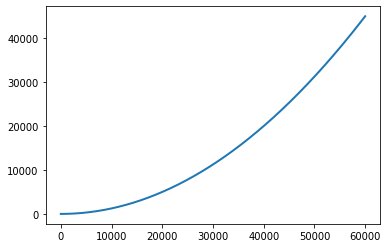

In [62]:
fig, ax = plt.subplots()

ax.plot(T, state[0, :], linewidth=2.0)

plt.show()